# Projekt klasyfikacja

Projekt klasyfikacyjny będzie polegać na stworzeniu modelu regresji logistycznej dla analizy churn. 
Cel biznesowy: Zaprognozowanie klientów chcących zrezygnować z usług, w celu szybszej reakcji i przedstawieniu konkurencyjnej oferty, co zmniejszy odsetek odejść.

Kroki do realizacji:
1. Wczytanie i przejrzenie danych.
2. Analiza braków danych.
3. Zbadaj udział odejść dla umów terminowych i bezterminowych (podpowiedź: umowy na czas nieokreślony mają wartość reamining_contract pustą)
4. Stwórz model dla kontraktów terminowych. Wykonaj poniższe kroki:
    - Selekcja zmiennych.
    - Badanie outlierów.
    - Wydzielenie zbioru treningowego i testowego.
    - Stworzenie modelu regresji logistycznej.
    - Ocena modelu.

Zbiór danych: https://www.kaggle.com/datasets/mehmetsabrikunt/internet-service-churn

Zmienne w zbiorze:
- id - unikalny klucz
- is_tv_subscriber - czy klient ma wykupiony pakiet telewizji? (1-tak/0-nie)
- is_movie_package_subscriber - czy klient ma pakiet filmowy? (1-tak/0-nie)
- subscription_age - liczba lat, od kiedy klient ma usługi firmy.
- bill_avg - średnia kwota rachunku z ostatinch 3 miesięcy.
- reamining_contract - ile czasu pozostało do końca umowy. W przypadku wartości pustej, nie ma umowy terminowej.
- service_failure_count - liczba telefonów klienta w celu zgłodzenia awarii.
- download_avg - średnie zużycie internetu w ostatnich 3 miesiącach.
- upload_avg - średnie upload w ostatnich 3 miesiącach.
- download_over_limit - zmienna informująca o pobieraniu powyżej limitu
- churn - 1 oznacza, że klient anulował usługi.

In [1]:
import pandas as pd
import os

In [2]:
# Pobranie danych
os.chdir('../')

df = pd.read_csv('data/internet_service_churn.csv')

In [3]:
df.columns

Index(['id', 'is_tv_subscriber', 'is_movie_package_subscriber',
       'subscription_age', 'bill_avg', 'reamining_contract',
       'service_failure_count', 'download_avg', 'upload_avg',
       'download_over_limit', 'churn'],
      dtype='object')

In [4]:
df.head()

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
0,15,1,0,11.95,25,0.14,0,8.4,2.3,0,0
1,18,0,0,8.22,0,NaN,0,0.0,0.0,0,1
2,23,1,0,8.91,16,0.00,0,13.7,0.9,0,1
3,27,0,0,6.87,21,NaN,1,0.0,0.0,0,1
4,34,0,0,6.39,0,NaN,0,0.0,0.0,0,1


In [5]:
df.describe()

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
count,7.227400e+04,72274.000000,72274.000000,72274.000000,72274.000000,50702.000000,72274.000000,71893.000000,71893.000000,72274.000000,72274.000000
mean,8.463182e+05,0.815259,0.334629,2.450051,18.942483,0.716039,0.274234,43.689911,4.192076,0.207613,0.554141
std,4.891022e+05,0.388090,0.471864,2.034990,13.215386,0.697102,0.816621,63.405963,9.818896,0.997123,0.497064
min,1.500000e+01,0.000000,0.000000,-0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.222165e+05,1.000000,0.000000,0.930000,13.000000,0.000000,0.000000,6.700000,0.500000,0.000000,0.000000
50%,8.477840e+05,1.000000,0.000000,1.980000,19.000000,0.570000,0.000000,27.800000,2.100000,0.000000,1.000000
75%,1.269562e+06,1.000000,1.000000,3.300000,22.000000,1.310000,0.000000,60.500000,4.800000,0.000000,1.000000
max,1.689744e+06,1.000000,1.000000,12.800000,406.000000,2.920000,19.000000,4415.200000,453.300000,7.000000,1.000000


2. Analiza braków danych

In [6]:
df.isna().sum()

id                                 0
is_tv_subscriber                   0
is_movie_package_subscriber        0
subscription_age                   0
bill_avg                           0
reamining_contract             21572
service_failure_count              0
download_avg                     381
upload_avg                       381
download_over_limit                0
churn                              0
dtype: int64

In [7]:
# Usunięcie rekordów z download_avg puste
df = df[~(df['download_avg'].isna())].reset_index(drop=True)

In [8]:
df.isna().sum()

id                                 0
is_tv_subscriber                   0
is_movie_package_subscriber        0
subscription_age                   0
bill_avg                           0
reamining_contract             21518
service_failure_count              0
download_avg                       0
upload_avg                         0
download_over_limit                0
churn                              0
dtype: int64

3. Zbadaj udział odejść dla umów terminowych i bezterminowych (podpowiedź: umowy na czas nieokreślony mają wartość reamining_contract pustą)

In [9]:
df['is_fixed_term'] = (~(df['reamining_contract'].isna())).astype(int)

In [10]:
df['is_fixed_term'].value_counts()

is_fixed_term
1    50375
0    21518
Name: count, dtype: int64

In [11]:
df_fixed_term = df[df['is_fixed_term']==1].reset_index(drop = True)
df_indefinite = df[df['is_fixed_term']==0].reset_index(drop = True)

In [12]:
# udział odejść
df.churn.value_counts()/df.shape[0]

churn
1    0.557078
0    0.442922
Name: count, dtype: float64

In [13]:
df_fixed_term.churn.value_counts()/df_fixed_term.shape[0]

churn
0    0.596407
1    0.403593
Name: count, dtype: float64

In [16]:
df_indefinite.churn.value_counts()/df_indefinite.shape[0]

churn
1    0.916396
0    0.083604
Name: count, dtype: float64

Zmienna określająca czy umowa jest terminowa wpływa w bardzo dużym stopniu na prawdopodobieństwo zajścia zdarzenia. Można ją użyć w modelu, jednak istnieje ryzyko, że model przypisze dla każdej umowy bezterminowej prognozowaną klasę jako 1.

Dobrą praktyką jest w takich przypadkach stworzenie osobnych modeli dla umów terminowych i bezterminowych.
Mówi się o takich zmiennych jako o istotnych zmiennych różnicujących. Mogą one być też wybrane z uwagi na założenia biznesowe.

4. Stwórz model dla kontraktów terminowych.

Zadajmy sobie pytanie czy dla umów terminowych, chcemy prognozować przypadki, dla których do końca umowy pozostało dużo czasu. 
Można w tej sytuacji:
1. Modelować dla wszystkich
2. Usunąć przypadki, gdzie do końca umowy pozostało bardzo dużo czasu.
3. Stworzyć osobne modele dla przypadków, gdzie do końca umowy pozostało niewiele czasu i dla pozostałych.

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt 

<Axes: xlabel='reamining_contract', ylabel='Density'>

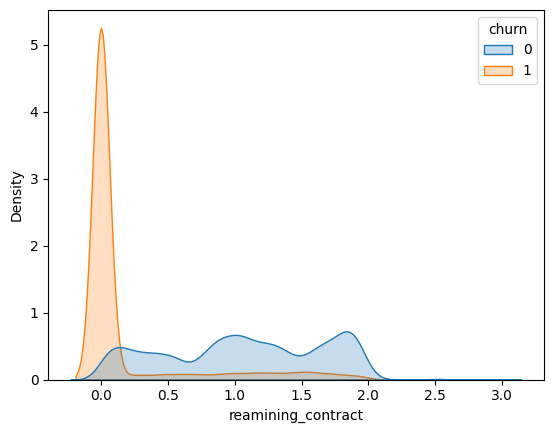

In [18]:
#histogram czasu do końca umowy

sns.kdeplot(data=df_fixed_term, x= 'reamining_contract', hue= 'churn', fill=True,common_norm=False )
plt.show()

In [20]:
df_fixed_term.groupby('churn').describe(percentiles=[0.75,0.8,0.85,0.9,.05,.98,0.99])['reamining_contract']

,count,mean,std,min,5%,50%,75%,80%,85%,90%,98%,99%,max
churn,,,,,,,,,,,,,
0,30044.0,1.066808,0.591818,0.0,0.09,1.08,1.61,1.7,1.790,1.85,1.95,1.97,2.92
1,20331.0,0.183152,0.458280,0.0,0.00,0.00,0.00,0.0,0.355,0.96,1.73,1.85,2.31


In [21]:
# filtrowanie danych wg konca umowy
threshold = 90/365
df_fixed_term_new = df_fixed_term[df_fixed_term['reamining_contract']<=threshold]
df_fixed_term_new.shape

(20896, 12)

In [23]:
korelacja = df_fixed_term_new.corr(method='spearman')['churn']
korelacja

id                            -0.167114
is_tv_subscriber              -0.183614
is_movie_package_subscriber   -0.236402
subscription_age              -0.351624
bill_avg                      -0.101693
reamining_contract            -0.884666
service_failure_count          0.012023
download_avg                  -0.344094
upload_avg                    -0.328783
download_over_limit            0.087006
churn                          1.000000
is_fixed_term                       NaN
Name: churn, dtype: float64

In [26]:
x_names = [i for i in korelacja.index if abs(korelacja[i])>=0.15 and i not in ['id','churn','reamining_contract']]

In [27]:
x_names

['is_tv_subscriber',
 'is_movie_package_subscriber',
 'subscription_age',
 'download_avg',
 'upload_avg']

Wyznaczanie outlierow

In [32]:
from funkcje_pomocnicze import find_outliers

In [33]:
x_numerical = ['subscription_age',
 'download_avg',
 'upload_avg']

In [40]:
outliers_names = []
for i in x_numerical:
    df_fixed_term_new.loc[:,f'{i}_outlier'] = find_outliers(df.loc[df[i]>0,i])
    outliers_names.append(f'{i}_outlier')


In [41]:
df_fixed_term_new.loc[:,'outlier_total'] = df_fixed_term_new.loc[:,outliers_names].max(axis=1)

In [42]:
df_fixed_term_new.loc[:,'outlier_total'].value_counts()

outlier_total
False    18124
True      2729
Name: count, dtype: int64

In [43]:
df_fixed_term_new = df_fixed_term_new[df_fixed_term_new['outlier_total']==0]

Podział na train i test

In [44]:
from sklearn.model_selection import train_test_split

In [45]:
train_x, test_x, train_y, test_y = train_test_split(df_fixed_term_new[x_names], df_fixed_term_new['churn'],test_size=0.3, random_state=123)

In [46]:
from sklearn.linear_model import LogisticRegression

Modelowanie

In [47]:
model_1 = LogisticRegression().fit(train_x,train_y)

In [48]:
train_pred  =model_1.predict(train_x)
test_pred  =model_1.predict(test_x)

In [50]:
from sklearn.metrics import classification_report

Ocena jakości

In [52]:
print(classification_report(train_y, train_pred))

              precision    recall  f1-score   support

           0       0.62      0.27      0.38      2302
           1       0.86      0.96      0.91     10384

    accuracy                           0.84     12686
   macro avg       0.74      0.62      0.64     12686
weighted avg       0.81      0.84      0.81     12686



In [54]:
print(classification_report(test_y,test_pred))

              precision    recall  f1-score   support

           0       0.63      0.29      0.39       970
           1       0.86      0.96      0.91      4468

    accuracy                           0.84      5438
   macro avg       0.75      0.62      0.65      5438
weighted avg       0.82      0.84      0.82      5438

